In [2]:
!pip install yfinance
!pip install pandas_ta
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier


     |████████████████████████████████| 6.4 MB 7.2 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 115 kB 5.0 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=a30981864e5fcde31e17cb2b581884e573cd0d61c5ef1b6405537885f76b6cf

In [3]:
# Load silver price
df = yf.Ticker("SI=F")
data = df.history(period="max")
data.drop([column for column in data.columns if column not in ['Close', 'High', 'Low']], axis=1, inplace=True)

In [4]:
# Add gold price
df = yf.Ticker("GC=F")
gold = df.history(period="max")
data['Gold'] = gold['Close']

In [5]:
data.isna().sum()

High     0
Low      0
Close    0
Gold     3
dtype: int64

In [6]:
data['Gold'].fillna(method='ffill', inplace=True)

In [7]:
data.isna().sum()

High     0
Low      0
Close    0
Gold     0
dtype: int64

In [8]:
data.tail()

,High,Low,Close,Gold
Date,,,,
2022-04-19,26.035000,25.391001,25.391001,1955.699951
2022-04-20,25.270000,25.215000,25.270000,1952.300049
2022-04-21,25.280001,24.621000,24.621000,1944.900024
2022-04-22,24.725000,24.215000,24.257000,1931.000000
2022-04-25,24.240000,23.575001,23.594999,1912.800049


In [9]:
# Add Silver and Gold price change 10, 30, 100 days in percentage points
windows = [10, 30, 100]
for window in windows:
    data["Silver_"+str(window)] = data['Close'].rolling(window+1).apply(lambda x: (x.iloc[window] - x.iloc[0]) / x.iloc[0] * 100)
    data["Gold_"+str(window)] = data['Gold'].rolling(window+1).apply(lambda x: (x.iloc[window] - x.iloc[0]) / x.iloc[0] * 100)

In [10]:
data.tail()

,High,Low,Close,Gold,Silver_10,Gold_10,Silver_30,Gold_30,Silver_100,Gold_100
Date,,,,,,,,,,
2022-04-19,26.035000,25.391001,25.391001,1955.699951,3.282627,1.373626,-1.252279,-1.915847,8.346496,9.655170
2022-04-20,25.270000,25.215000,25.270000,1952.300049,3.025117,1.528942,-6.017554,-4.303707,7.550222,9.427727
2022-04-21,25.280001,24.621000,24.621000,1944.900024,0.678799,1.381359,-4.410450,-2.064555,6.552127,8.939672
2022-04-22,24.725000,24.215000,24.257000,1931.000000,-1.924554,-0.144795,-7.423096,-3.358189,6.395018,8.343149
2022-04-25,24.240000,23.575001,23.594999,1912.800049,-4.931709,-1.483309,-9.618484,-3.525491,3.645947,7.848448


In [11]:
# Add technical indicators RSI, MACD and Stochastic Oscillator for Silver
data['RSI_14']=ta.rsi(data['Close'],lenght=14)

MACD = ta.macd(data['Close'],fast=12, slow=26, signal=9)
data = pd.concat([data,MACD],axis=1)

STOCH = ta.stoch(high=data.High,low=data.Low,close=data.Close)
data = pd.concat([data, STOCH], axis=1)

In [12]:
data.tail()

,High,Low,Close,Gold,Silver_10,Gold_10,Silver_30,Gold_30,Silver_100,Gold_100,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,STOCHk_14_3_3,STOCHd_14_3_3
Date,,,,,,,,,,,,,,,,
2022-04-19,26.035000,25.391001,25.391001,1955.699951,3.282627,1.373626,-1.252279,-1.915847,8.346496,9.655170,52.291604,0.200412,0.073393,0.127020,79.820817,87.445501
2022-04-20,25.270000,25.215000,25.270000,1952.300049,3.025117,1.528942,-6.017554,-4.303707,7.550222,9.427727,51.028816,0.176698,0.039743,0.136955,70.018551,81.145463
2022-04-21,25.280001,24.621000,24.621000,1944.900024,0.678799,1.381359,-4.410450,-2.064555,6.552127,8.939672,44.782169,0.104334,-0.026097,0.130431,41.888926,63.909431
2022-04-22,24.725000,24.215000,24.257000,1931.000000,-1.924554,-0.144795,-7.423096,-3.358189,6.395018,8.343149,41.698991,0.017412,-0.090416,0.107827,23.153213,45.020230
2022-04-25,24.240000,23.575001,23.594999,1912.800049,-4.931709,-1.483309,-9.618484,-3.525491,3.645947,7.848448,36.744217,-0.103697,-0.169220,0.065522,6.190869,23.744336


In [13]:
# Prepare the target - Silver price direction change over next window days
window = 10
data['Target'] = data['Close'].rolling(window + 1).apply(lambda x: x.iloc[window] > x.iloc[0]) 

In [14]:
# We want to know the future outcome pre-fact to train our model
data['Target'] = data['Target'].shift(-window)

In [15]:
data.shape

(5433, 17)

In [16]:
data.isna().sum()

High               0
Low                0
Close              0
Gold               0
Silver_10         10
Gold_10           10
Silver_30         30
Gold_30           30
Silver_100       100
Gold_100         100
RSI_14            14
MACD_12_26_9      25
MACDh_12_26_9     33
MACDs_12_26_9     33
STOCHk_14_3_3     15
STOCHd_14_3_3     17
Target            10
dtype: int64

In [17]:
# Remove first 100 rows (missing values for technical indicators) and last 10 rows (missing Target)
data.dropna(axis=0, inplace=True)
data.isna().sum().sum()

0

In [18]:
# Saving copy of clean data
data.to_csv('data.csv')

In [19]:
data.columns

Index(['High', 'Low', 'Close', 'Gold', 'Silver_10', 'Gold_10', 'Silver_30',
       'Gold_30', 'Silver_100', 'Gold_100', 'RSI_14', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'STOCHk_14_3_3', 'STOCHd_14_3_3',
       'Target'],
      dtype='object')

In [20]:
# We can remove first 4 columns, as we are not interested in present nominal values
data.drop(['High','Low','Close','Gold'], axis=1, inplace=True)

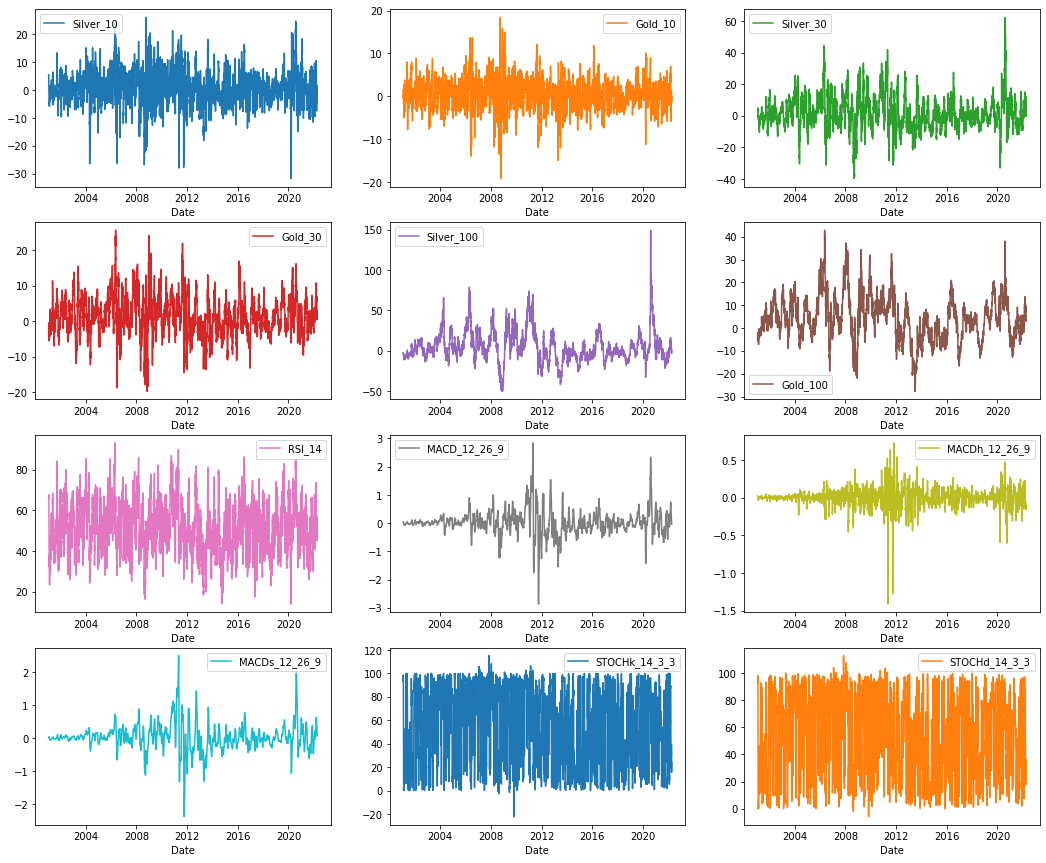

In [21]:
features = data[[column for column in data.columns if column !='Target']]
features.plot(subplots=True, sharex=False, layout=(4,3), figsize=(18,15))
plt.show()

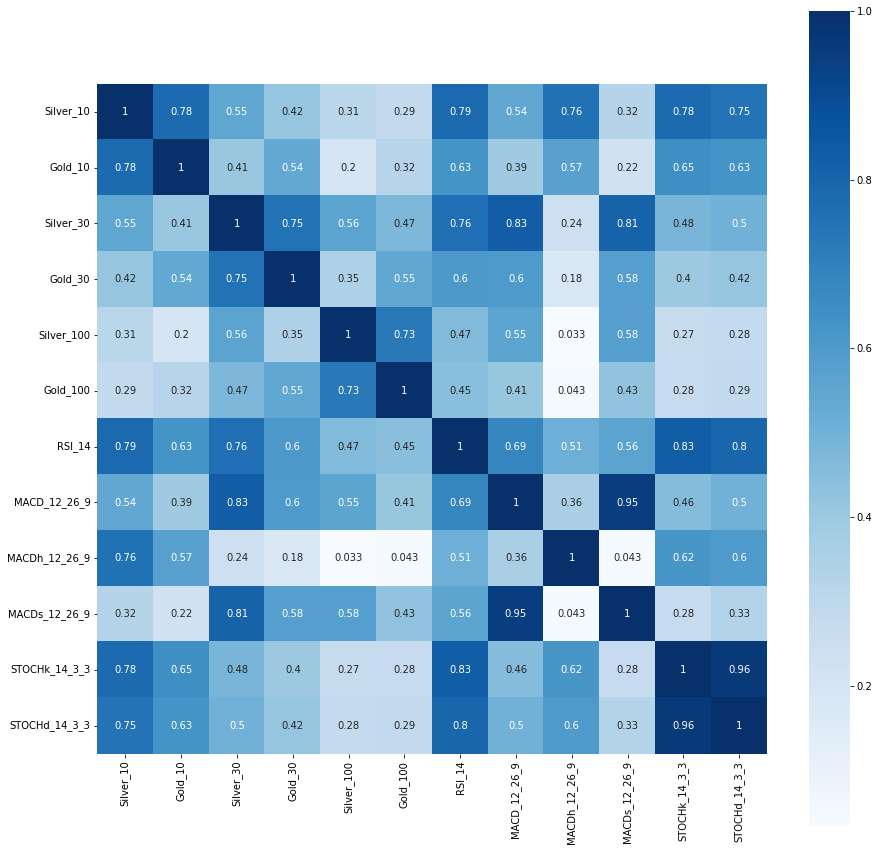

In [22]:
plt.figure(figsize=(15,15))
sns.heatmap(features.corr(),square=True,cmap="Blues",annot=True)
plt.show()

In [23]:
target = data['Target']

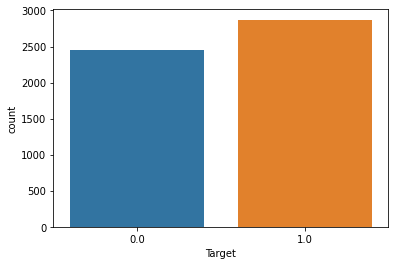

In [24]:
sns.countplot(target)
plt.show()

In [25]:
# For model selection, we will select the most promising models taking into account our previous projects and financial literature.
models = []
models.append(('RF', RandomForestClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('GRAD', GradientBoostingClassifier()))